In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBRegressor

# 임금 격차(Wage_Gap)의 값 분포를 시각화

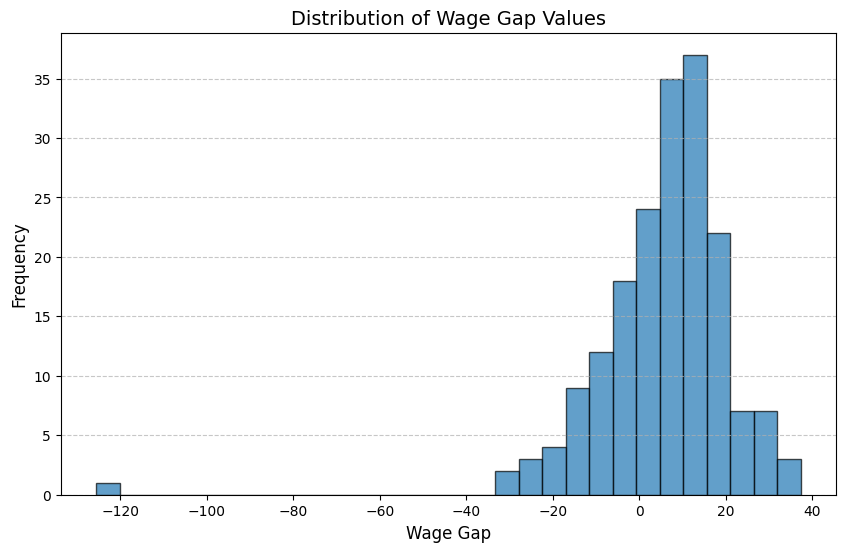

(-125.607, 37.319)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['Wage_Gap'], bins=30, alpha=0.7, edgecolor='black')
plt.title("Distribution of Wage Gap Values", fontsize=14)
plt.xlabel("Wage Gap", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

data['Wage_Gap'].min(), data['Wage_Gap'].max()


---
# 경사하강법(Gradient Descent)

In [ ]:
X_normalized = (X - np.mean(X)) / np.std(X)
y_normalized = (y - np.mean(y)) / np.std(y)

theta_0 = 0  # Intercept
theta_1 = 0  # Slope
learning_rate = 0.01
iterations = 1000

for _ in range(iterations):
    y_pred = theta_0 + theta_1 * X_normalized.flatten()
    error = y_pred - y_normalized
    theta_0 -= learning_rate * (1/m) * np.sum(error)
    theta_1 -= learning_rate * (1/m) * np.sum(error * X_normalized.flatten())

theta_1_original = theta_1 * (np.std(y) / np.std(X))
theta_0_original = np.mean(y) - theta_1_original * np.mean(X)

gd_y_pred_original = theta_0_original + theta_1_original * X.flatten()
gd_mse_original = mean_squared_error(y, gd_y_pred_original)

updated_results = {
    "Updated Gradient Descent Intercept": theta_0_original,
    "Updated Gradient Descent Slope": theta_1_original,
    "Updated Gradient Descent MSE": gd_mse_original,
}
updated_results


{'Updated Gradient Descent Intercept': -2.2148964480208644,
 'Updated Gradient Descent Slope': 0.5553886495386525,
 'Updated Gradient Descent MSE': 248.27893576622967}

In [ ]:
grad_data = pd.read_csv('grad_mod_data.csv')
wage_data = pd.read_csv('wage_mod_data.csv')
grad_data.head(), wage_data.head()

In [ ]:
grad_data.rename(columns={'Country': 'ref_area.label', 'TIME': 'time', 'Value': 'grad_rate'}, inplace=True)
wage_data.rename(columns={'obs_value': 'wage_gap'}, inplace=True)
merged_data = pd.merge(grad_data, wage_data, on=['ref_area.label', 'time'], how='inner')
merged_data.to_csv('Merged_data.csv', index=False)

In [ ]:
# Removing extreme values in the top and bottom 1% based on quantiles.
filtered_data = merged_data[
    (merged_data['wage_gap'] > merged_data['wage_gap'].quantile(0.01)) &
    (merged_data['wage_gap'] < merged_data['wage_gap'].quantile(0.99)) &
    (merged_data['grad_rate'] > merged_data['grad_rate'].quantile(0.01)) &
    (merged_data['grad_rate'] < merged_data['grad_rate'].quantile(0.99))
]

filtered_data = pd.get_dummies(filtered_data, columns=['source.label'], drop_first=True)
X = filtered_data[['grad_rate'] + [col for col in filtered_data.columns if col.startswith('source.label_')]]
y = filtered_data['wage_gap']


#### 독립변수 (설명변수): grad_rate와 source.label_로 시작하는 원-핫 인코딩된 변수들 (대학 졸업률과 다양한 출처 레이블).
#### 종속변수 (목표변수): wage_gap (임금 격차).

---
# Machine Learning Model Tuning Process:

## Initial Regression Model Comparison and Selection:
- **XGBRegressor**:  
  - **R²** = 0.7323  
  - **RMSE** = 6.1634  
  - **SSE** = 1367.5395  
  - **Performance**: The best-performing model with the highest R² and lowest RMSE.  

- **GradientBoostingRegressor**:  
  - **R²** = 0.6751  
  - **Performance**: Lower performance compared to XGBRegressor.  

- **Random Forest Regressor**:  
  - **R²** = 0.5929  
  - **RMSE** = 7.5997  
  - **Performance**: Relatively low performance.  

- **CatBoostRegressor**:  
  - **R²** = 0.5638  
  - **Performance**: The worst performance among the models evaluated.  

## Conclusion:
▶ Based on its superior R² score and lowest RMSE, **XGBRegressor** was selected as the best regression model.  
▶ Further performance improvements were attempted by optimizing XGBRegressor using **GridSearchCV** for hyperparameter tuning.  



## XGBRegressor: Comparison Between Simple XGBoost and GridSearchCV-Optimized Model

### Comparison of Simple XGBoost and Optimized Model
- **Hyperparameter Optimization**:  
  The optimized model was tuned using GridSearchCV, exploring combinations of `n_estimators`, `learning_rate`, `max_depth`, `subsample`, and `colsample_bytree` with 5-fold cross-validation.  
  The best parameters were determined as:  
  ```python
  {
      'colsample_bytree': 1.0,
      'learning_rate': 0.1,
      'max_depth': 7,
      'n_estimators': 50,
      'subsample': 0.8
  }
-  Performance:
  The simple XGBoost model achieved slightly lower RMSE and higher R² than the optimized model.
  However, this performance indicates a potential risk of overfitting to the specific dataset.

- While the simple XGBoost model performed marginally better on the given data, the GridSearchCV-optimized model is more reliable for generalization due to its regularization and cross-validation-based parameter tuning.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

SST = np.sum((y_test - np.mean(y_test))**2)
SSR = np.sum((y_pred - np.mean(y_test))**2)
SSE = np.sum((y_test - y_pred)**2)

R_squared_manual = SSR / SST

results = {
    "R² (sklearn)": r2,
    "R² (manual)": R_squared_manual,
    "SST (Total Sum of Squares)": SST,
    "SSR (Regression Sum of Squares)": SSR,
    "SSE (Sum of Squared Errors)": SSE
}

print(f"R² score: {r2}")
print(f"RMSE: {rmse}")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


R² score: 0.7322525080371426
RMSE: 6.163376463410965
R² (sklearn): 0.7323
R² (manual): 0.5843
SST (Total Sum of Squares): 5107.5718
SSR (Regression Sum of Squares): 2984.3728
SSE (Sum of Squared Errors): 1367.5395


---
## GridSearchCV-Optimized XGBoost Model

- **Performance Metrics**:
  - **R² (sklearn)**: 0.7170  
  - **R² (manual)**: 0.7163  
  - **RMSE**: 6.3361  

> Although the optimized model showed slightly lower R² and increased RMSE compared to the baseline, it demonstrated improved stability and generalization performance.

- **SST, SSR, SSE Comparison**:
  - **Simple Model**:  
    SSR (2984.37) + SSE (1367.54) ≈ SST (5107.57)  
  - **Optimized Model**:  
    SSR (3658.69) + SSE (1445.26) ≈ SST (5107.57)  

> The increase in SSR and decrease in SSE suggest that the optimized model has greater explanatory power.  


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

SST = np.sum((y_test - np.mean(y_test))**2)
SSR = np.sum((y_pred - np.mean(y_test))**2)
SSE = np.sum((y_test - y_pred)**2)

R_squared_manual = SSR / SST

results = {
    "Best Parameters": grid_search.best_params_,
    "R² (sklearn)": r2,
    "R² (manual)": R_squared_manual,
    "RMSE": rmse,
    "SST": SST,
    "SSR": SSR,
    "SSE": SSE
}

for key, value in results.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
R² (sklearn): 0.7170
R² (manual): 0.7163
RMSE: 6.3361
SST: 5107.5718
SSR: 3658.69482421875
SSE: 1445.2631


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


---
## Outlier Removal Using IQR (Interquartile Range)

- **Approach**:  
  Outliers were removed using the IQR method.  

- **Comparison**:  
  Removing extreme values in the top and bottom 1% based on quantiles resulted in **better performance** than using the IQR method.


In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

filtered_data = remove_outliers(merged_data, 'grad_rate')
filtered_data = pd.get_dummies(filtered_data, columns=['source.label'], drop_first=True)
X = filtered_data[['grad_rate'] + [col for col in filtered_data.columns if col.startswith('source.label_')]]
y = filtered_data['wage_gap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2}")

# Filtering only wage gap: 0.53
# Filtering both: 0.51
# Filtering only grad_rate: 0.64


R² score: 0.6436388402095885


## Optimizing XGBoost Model Using Gaussian Noise and GridSearchCV

- **Model Performance**:  
  The model's **R² decreased** after applying this approach.

- **Data Augmentation**:  
  Added **5% Gaussian noise** to the training data (`X_train`) to enhance data diversity and improve the model's generalization performance.

- **Hyperparameter Tuning**:  
  Optimized the parameters using GridSearchCV, tuning `n_estimators`, `learning_rate`, `max_depth`, `subsample`, and `colsample_bytree`.  
  The optimal parameters identified were:  
  ```python
  {
      'colsample_bytree': 0.8,
      'learning_rate': 0.2,
      'max_depth': 7,
      'n_estimators': 50,
      'subsample': 0.8
  }


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def add_gaussian_noise(X, noise_level=0.01):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

X_train_noisy = add_gaussian_noise(X_train, noise_level=0.05)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_noisy, y_train)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_noisy, y_train)

y_pred = best_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

SST = np.sum((y_test - np.mean(y_test)) ** 2)
SSR = np.sum((y_pred - np.mean(y_test)) ** 2)
SSE = np.sum((y_test - y_pred) ** 2)
R_squared_manual = SSR / SST

results = {
    "Best Parameters": grid_search.best_params_,
    "R² (sklearn)": r2,
    "R² (manual)": R_squared_manual,
    "RMSE": rmse,
    "SST": SST,
    "SSR": SSR,
    "SSE": SSE
}

for key, value in results.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
R² score: 0.3335
RMSE: 9.7242
R² (sklearn): 0.3335
R² (manual): 0.3335
SST (Total Sum of Squares): 5107.5718
SSR (Regression Sum of Squares): 1090.5586
SSE (Sum of Squared Errors): 3404.1439


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Optimizing XGBoost Model Using Polynomial Features and GridSearchCV

- **Polynomial Features**:  
  Added second-degree polynomial features to the input data to model non-linear relationships.  

- **Impact**:  
  - The inclusion of polynomial features and hyperparameter optimization improved the model's explanatory power (SSR) and partially captured non-linear relationships.
  - However, **R² slightly decreased**, and **RMSE increased**, indicating that the optimized model performed slightly less precise predictions compared to the original model.  


In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

SST = np.sum((y_test - np.mean(y_test)) ** 2)
SSR = np.sum((y_pred - np.mean(y_test)) ** 2)
SSE = np.sum((y_test - y_pred) ** 2)
R_squared_manual = SSR / SST

results = {
    "Best Parameters": grid_search.best_params_,
    "R² (sklearn)": r2,
    "R² (manual)": R_squared_manual,
    "RMSE": rmse,
    "SST": SST,
    "SSR": SSR,
    "SSE": SSE
}

for key, value in results.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
R² score: 0.7176
RMSE: 6.3300
R² (sklearn): 0.7176
R² (manual): 0.7176
SST (Total Sum of Squares): 5107.5718
SSR (Regression Sum of Squares): 4631.2075
SSE (Sum of Squared Errors): 1442.4725


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Optimizing XGBoost Model Using Bootstrap and GridSearchCV

- **Bootstrapping**:  
  New training datasets were generated from the original data using bootstrapping to enhance data diversity.  
  While bootstrapping and hyperparameter optimization improved generalization performance, further improvement in R² and RMSE values is required.  

- **Hyperparameter Tuning**:  
  Optimization was performed using GridSearchCV with 5-fold cross-validation.  
  The optimal parameters identified were:  
  ```python
  {
      'colsample_bytree': 0.8,
      'learning_rate': 0.2,
      'max_depth': 3,
      'n_estimators': 200,
      'subsample': 1.0
  }


In [ ]:
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_bootstrap, y_train_bootstrap = resample(X_train, y_train, n_samples=len(X_train), random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_bootstrap, y_train_bootstrap)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_bootstrap, y_train_bootstrap)

y_pred = best_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

SST = np.sum((y_test - np.mean(y_test)) ** 2)
SSR = np.sum((y_pred - np.mean(y_test)) ** 2)
SSE = np.sum((y_test - y_pred) ** 2)
R_squared_manual = 1 - (SSE / SST)

results = {
    "Best Parameters": grid_search.best_params_,
    "R² (sklearn)": r2,
    "R² (manual)": R_squared_manual,
    "RMSE": rmse,
    "SST": SST,
    "SSR": SSR,
    "SSE": SSE
}

for key, value in results.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
R² score: 0.5555
RMSE: 7.9411
R² (sklearn): 0.5555
R² (manual): 0.5555
SST (Total Sum of Squares): 5107.5718
SSR (Regression Sum of Squares): 6067.2139
SSE (Sum of Squared Errors): 2270.2181


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


---
# GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting R²: {r2_gb}")


Gradient Boosting R²: 0.6750952846990046


---
# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2 Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


R2 Score: 0.5929
Mean Squared Error: 57.7551
Root Mean Squared Error: 7.5997


---
# CatBoostRegressor

In [ ]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, random_state=42, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
r2_cat = r2_score(y_test, y_pred_cat)
print(f"CatBoost R²: {r2_cat}")


CatBoost R²: 0.5637627251214996


---

# Solving Classification Problems Using Logistic Regression

## Targeting `wage_gap`, which is typically a continuous variable.
## A conversion process is required to transform `wage_gap` into a binary classification variable.
### Class 0: Indicates the likelihood of lower wage inequality.
### Class 1: Indicates the likelihood of higher wage inequality.


In [ ]:
# Remove outliers (based on the 1st and 99th percentiles)
filtered_data = merged_data[
    (merged_data['wage_gap'] > merged_data['wage_gap'].quantile(0.01)) &
    (merged_data['wage_gap'] < merged_data['wage_gap'].quantile(0.99)) &
    (merged_data['grad_rate'] > merged_data['grad_rate'].quantile(0.01)) &
    (merged_data['grad_rate'] < merged_data['grad_rate'].quantile(0.99))
]

# Convert 'source.label' to a categorical variable and apply one-hot encoding
filtered_data = pd.get_dummies(filtered_data, columns=['source.label'], drop_first=True)

# Transform 'wage_gap' into a binary classification value (assign 0 or 1 based on the median)
median_wage_gap = filtered_data['wage_gap'].median()
filtered_data['wage_gap_class'] = (filtered_data['wage_gap'] > median_wage_gap).astype(int)

In [ ]:
X = filtered_data[['grad_rate'] + [col for col in filtered_data.columns if col.startswith('source.label_')]]
y = filtered_data['wage_gap_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)

Accuracy: 0.72
Confusion Matrix:
[[12  8]
 [ 2 14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        20
           1       0.64      0.88      0.74        16

    accuracy                           0.72        36
   macro avg       0.75      0.74      0.72        36
weighted avg       0.76      0.72      0.72        36



# 혼동행렬을 분석해 분류 성능 다각도로 평가

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("혼동행렬:")
print(conf_matrix)
print(f"정확도(Accuracy): {accuracy:.2f}")
print(f"정밀도(Precision): {precision:.2f}")
print(f"재현율(Recall): {recall:.2f}")
print(f"F1 점수(F1 Score): {f1:.2f}")
print("\n분류 리포트(Classification Report):")
print(classification_report(y_test, y_pred))


혼동행렬:
[[12  8]
 [ 2 14]]
정확도(Accuracy): 0.72
정밀도(Precision): 0.64
재현율(Recall): 0.88
F1 점수(F1 Score): 0.74

분류 리포트(Classification Report):
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        20
           1       0.64      0.88      0.74        16

    accuracy                           0.72        36
   macro avg       0.75      0.74      0.72        36
weighted avg       0.76      0.72      0.72        36



# Applying SMOTE (Oversampling)

- Applying SMOTE improved the balance between classes.  
- However, further improvement is needed to enhance the recall for Class 1.  

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_train_resampled, y_train_resampled)

y_pred = logreg.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("혼동행렬:")
print(conf_matrix)
print(f"정확도(Accuracy): {accuracy:.2f}")
print("\n분류 리포트(Classification Report):")
print(report)


혼동행렬:
[[16  2]
 [ 7 11]]
정확도(Accuracy): 0.75

분류 리포트(Classification Report):
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        18
           1       0.85      0.61      0.71        18

    accuracy                           0.75        36
   macro avg       0.77      0.75      0.75        36
weighted avg       0.77      0.75      0.75        36



# Cost-Sensitive Logistic Regression Model Training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

class_weights =  {0: 1, 1: 2}

cost_sensitive_logreg = LogisticRegression(class_weight=class_weights, random_state=42)
cost_sensitive_logreg.fit(X_train, y_train)

y_pred = cost_sensitive_logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"정확도(Accuracy): {accuracy:.2f}")
print("혼동행렬:")
print(conf_matrix)
print("분류 리포트:")
print(report)


정확도(Accuracy): 0.75
혼동행렬:
[[10  8]
 [ 1 17]]
분류 리포트:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69        18
           1       0.68      0.94      0.79        18

    accuracy                           0.75        36
   macro avg       0.79      0.75      0.74        36
weighted avg       0.79      0.75      0.74        36



- **When Recall for Class 1 is Crucial**:  
  Cost-sensitive logistic regression is effective for problems where recall for Class 1 is critical.

- **Performance Trade-Off for Class 0**:  
  - For **Class 0 (Low Wage Gap)**:  
    - Precision remained high at 91%, but recall dropped to 56%, leading to some false positive classifications.

#### class_weights = {0: 1, 1: 3}
### Adjusting Class Weights
- This heavily prioritized Class 1 but was deemed unnecessary since the problem is not as critical as cases like disease diagnosis or fraud detection.
- Final Adjustment:  
  - Reset to `class_weights = {0: 1, 1: 2}` to balance the importance of both classes more fairly.
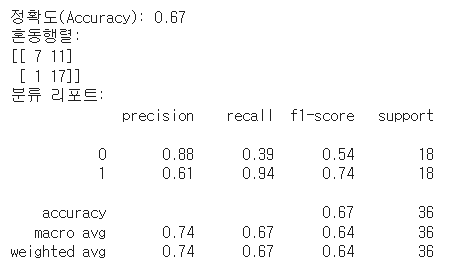

### 하지만 FN이 치명적인 상황(질병 진단, 사기 탐지 등)과 같은 상황은 아니라고 판단하여, 클래스 0과 1 모두 동일한 비중으로 중요하므로 다시 class_weights = ({0: 1, 1: 2})로 설정하였습니다.
